In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
# Determine the absolute path to your training data folder.
project_root = os.path.abspath(
    os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')
)

# Insert project_root to sys.path if needed.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Build the path to the data folder (assuming your data folder is directly under the project root)
data_dir = os.path.join(project_root, 'data')
data_small_dir = os.path.join(project_root, 'data_small')
data_small_dir = os.path.join(project_root, 'synth_data')

print("Project root:", project_root)
print("Data directory:", data_dir)

from models import get_model, mbconv_base,train_model,simple_base

from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

Project root: /home/phigep/fh/face-mask-detection
Data directory: /home/phigep/fh/face-mask-detection/data


2025-01-28 00:11:52.303131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738019512.314523   21607 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738019512.317967   21607 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 00:11:52.330991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1738019514.741752   21607 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21

In [3]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')
test_small_dir = os.path.join(data_small_dir, 'test')
test_synth_dir = os.path.join(data_small_dir, 'test')

In [4]:
BATCH_SIZE = 32
ORIGINAL_IMAGE_SIZE = (None, None)  # Allow variable sizes
TARGET_IMAGE_SIZE = (224, 224)       # EfficientNetV2's expected input size
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE
temperature = 0.15

In [5]:
from preprocessing import get_augmented_dataset
train_dataset = get_augmented_dataset(train_dir,batch_size=32)
validation_dataset = get_augmented_dataset(val_dir,batch_size=32,shuffle=True)
test_dataset = get_augmented_dataset(test_dir,batch_size=32,shuffle=False)
test_small_dataset = get_augmented_dataset(test_small_dir,batch_size=1,shuffle=False)




Found 73230 files belonging to 2 classes.
Found 36545 files belonging to 2 classes.
Found 19343 files belonging to 2 classes.
Found 399 files belonging to 2 classes.


In [6]:
from models import get_fcn_model,get_supervised_contrastive_loss
fcn_modelmbconv = get_fcn_model(mbconv_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2)


In [7]:
fcn_modelmbconv.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 7, 7, 128)      │       274,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,592 (1.11 MB)

 Trainable params: 282,080 (1.08 MB)

 Non-trainable params: 8,512 (33.25 KB)

In [8]:
from tensorflow.keras.utils import plot_model

# Generate a model plot
plot_model(fcn_modelmbconv, to_file='fcnmbconv.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [9]:
test_synth_dataset_shuffled = get_augmented_dataset(test_synth_dir,batch_size=4,shuffle=True)
test_small_dataset_shuffled = get_augmented_dataset(test_small_dir,batch_size=1,shuffle=True)

Found 399 files belonging to 2 classes.
Found 399 files belonging to 2 classes.


In [10]:
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=5e-5)

In [11]:

fcn_modelmbconv.compile(
    optimizer=optimizer,
    loss=get_supervised_contrastive_loss(0.1)
)


In [12]:
fcn_modelmbconv.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 7, 7, 128)      │       274,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,592 (1.11 MB)

 Trainable params: 282,080 (1.08 MB)

 Non-trainable params: 8,512 (33.25 KB)

In [13]:
import os
from models import get_fcn_model,get_supervised_contrastive_loss
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True,
    mode="min"
)


fcn_modelb = fcn_modelmbconv.fit(train_dataset,callbacks=[early_stopping],epochs=25)

Epoch 1/25


I0000 00:00:1738019530.018629   22219 service.cc:148] XLA service 0x7467fc044720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738019530.018680   22219 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-28 00:12:10.331800: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738019531.613804   22219 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-01-28 00:12:12.738316: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7370', 60 bytes spill stores, 64 bytes spill loads



   5/2289 ━━━━━━━━━━━━━━━━━━━━ 1:14 33ms/step - loss: 3.4699 

I0000 00:00:1738019540.083901   22219 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2289/2289 ━━━━━━━━━━━━━━━━━━━━ 124s 46ms/step - loss: 3.0290
Epoch 2/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 99s 43ms/step - loss: 2.8828
Epoch 3/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 99s 43ms/step - loss: 2.8518
Epoch 4/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 99s 43ms/step - loss: 2.8371
Epoch 5/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 99s 43ms/step - loss: 2.8307
Epoch 6/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 107s 46ms/step - loss: 2.8228
Epoch 7/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 104s 45ms/step - loss: 2.8170
Epoch 8/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - loss: 2.8078
Epoch 9/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 104s 45ms/step - loss: 2.8059
Epoch 10/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 105s 45ms/step - loss: 2.8032
Epoch 11/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 103s 45ms/step - loss: 2.7980
Epoch 12/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 105s 46ms/step - loss: 2.7944
Epoch 13/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 103s 45ms/step - loss: 2.7917
Epoch 14/25
2289/2289 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - loss: 2.7891
Ep

In [14]:
checkpoint_path = "./checkpoints/fcn_mbconv_250epoch_.weights.h5"
fcn_modelmbconv.save_weights(checkpoint_path)

In [15]:
checkpoint_path = "./checkpoints/fcn_mbconv_250epoch_.weights.h5"
fcn_modelmbconv.load_weights(checkpoint_path)

In [16]:
from models import HybridModel
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef, confusion_matrix
hybrid_mbconv_model = HybridModel(fcn = fcn_modelmbconv,clf= XGBClassifier(),train_dataset=train_dataset,validation_dataset=validation_dataset,test_dataset=test_dataset)


hybrid_mbconv_model.clf.fit(
    hybrid_mbconv_model.X_train, hybrid_mbconv_model.y_train,
    eval_set=[ (hybrid_mbconv_model.X_val, hybrid_mbconv_model.y_val)],           # or another metric suited to your problem         # stops training if validation metric doesn't improve for 10 rounds
    verbose=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

2025-01-28 00:58:30.749402: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

2025-01-28 01:00:02.556380: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
hybrid_mbconv_model.clf.save_model("./checkpoints/xgboost_mbconv_model250.bin")

/home/phigep/fh/face-mask-detection/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:00:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [18]:
print("Model parameters:")
print(hybrid_mbconv_model.clf.get_params())
y_pred = hybrid_mbconv_model.clf.predict(hybrid_mbconv_model.X_test)
mcoeff = matthews_corrcoef(hybrid_mbconv_model.y_test, y_pred)
print("Mathew Coeff", mcoeff)
confusion_matrix(hybrid_mbconv_model.y_test,y_pred)

Model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Mathew Coeff 0.9890968289698924


array([[10714,    55],
       [   49,  8510]])

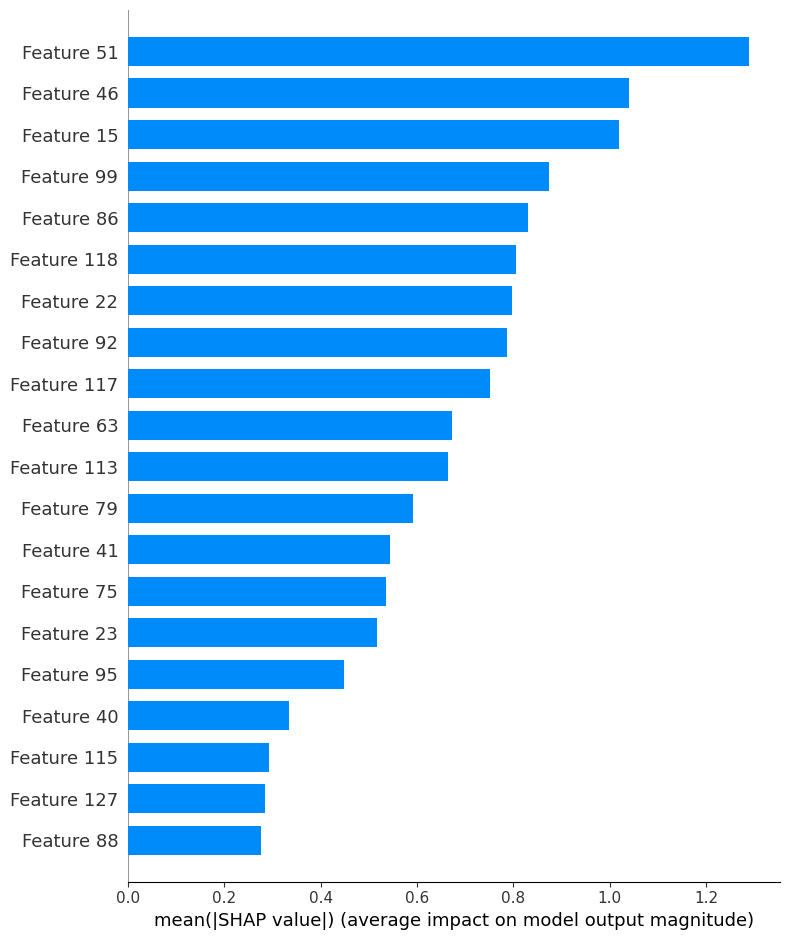

In [19]:
import shap
model = hybrid_mbconv_model.clf
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for your validation set (or use X_train as needed)
shap_values = explainer.shap_values(hybrid_mbconv_model.X_test)

# For binary classification, shap_values might be a list of two arrays,
# one for each class. Typically, we use the values for the positive class.
if isinstance(shap_values, list):
    # Use SHAP values for class 1, e.g. the "positive" class
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# Generate a bar summary plot of the top 20 most important features
shap.summary_plot(shap_values_to_plot, hybrid_mbconv_model.X_test, plot_type="bar", max_display=20)

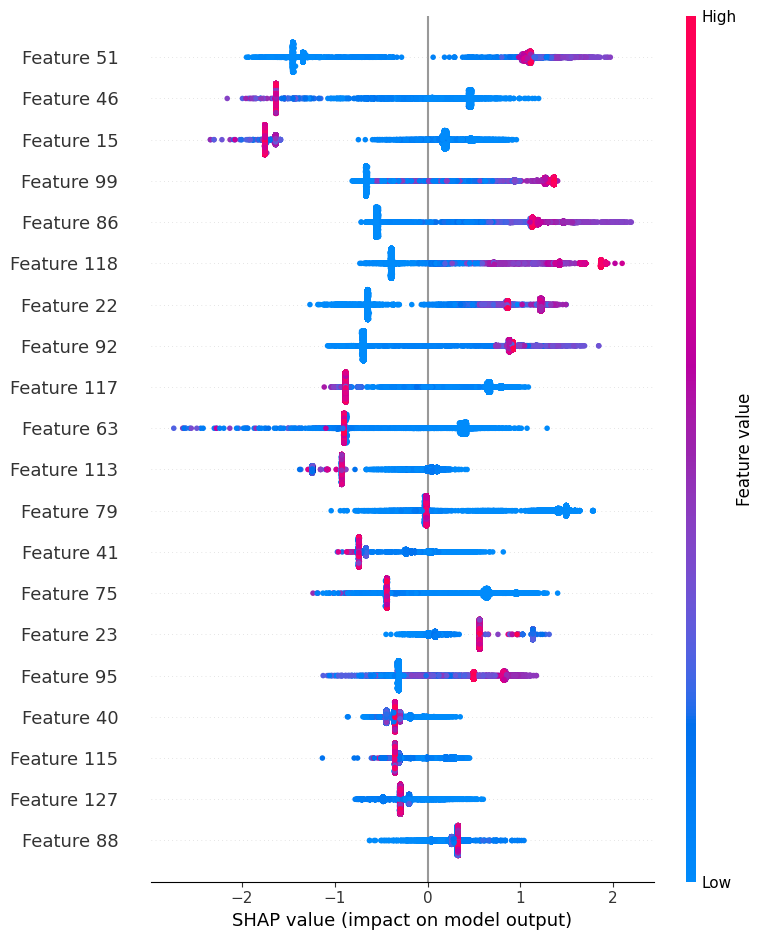

In [20]:
shap.initjs()
shap.summary_plot(shap_values, hybrid_mbconv_model.X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.252006   0.         0.         0.         0.         0.
  0.         0.         0.18625163 0.         0.         0.
  0.08215474 0.         0.         0.2750345  0.         0.
  0.         0.         0.         0.         0.         0.2862265
  0.         0.         0.2735627  0.         0.         0.
  0.         0.         0.         0.         0.         0.18646368
  0.         0.         0.         0.1829498  0.24412788 0.24563418
  0.         0.32015255 0.         0.         0.19653273 0.2344633
  0.         0.         0.13401408 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.20128173 0.         0.17214698 0.         0.
  0.         0.         0.         0.10519843 0.         0.
  0.         0.         0.1487954  0.22262277 0.         0.
  0.26200703 0.2206227  0.         0.         0.         0.
  0.         0.         0.         0.         0.25606704 0.17101324
  0.22579211 0.         

2025-01-28 01:01:00.068590: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


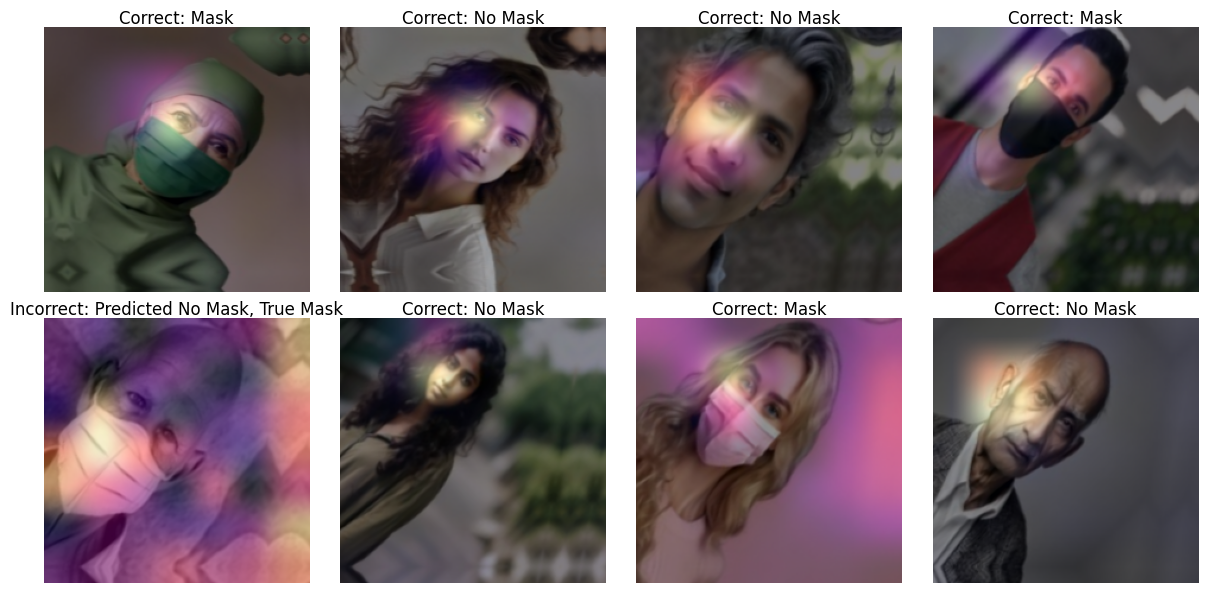

In [21]:
from eval import make_gradcam_heatmap, superimpose_gradcam,plot_images_grid
import matplotlib.pyplot as plt
import numpy as np
label_map = {0: "Mask", 1: "No Mask"}

captions = []
final_images=[]
for images, labels in test_small_dataset_shuffled.take(16):
    heatmap = make_gradcam_heatmap(model=fcn_modelmbconv,
                         last_conv_layer_name="functional_1",
                         img_array=images,
                         )
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=1)
    final_images.append(final)
    ftrs = hybrid_mbconv_model.fcn.predict(images)
    print(ftrs)
    preds = hybrid_mbconv_model.clf.predict(ftrs)
    if preds[0] == np.argmax(labels,axis=1)[0]:
        caption = f"Correct: {label_map[preds[0]]}"
    else:
        caption = f"Incorrect: Predicted {label_map[preds[0]]}, True {label_map[np.argmax(labels,axis=1)[0]]}"
    
    captions.append(caption)
p=plot_images_grid(final_images,captions=captions)

In [18]:
fcn_modelmbconv.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 14, 14, 128)    │       274,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 854,754 (3.26 MB)

 Trainable params: 282,080 (1.08 MB)

 Non-trainable params: 8,512 (33.25 KB)

 Optimizer params: 564,162 (2.15 MB)

In [19]:
import json
def count_nodes(tree):
    """Recursively count the number of nodes in a tree."""
    if 'children' not in tree:
        return 1
    return 1 + sum(count_nodes(child) for child in tree['children'])

def get_max_depth(tree, current_depth=0):
    """Recursively determine the maximum depth of a tree."""
    if 'children' not in tree:
        return current_depth
    return max(get_max_depth(child, current_depth + 1) for child in tree['children'])

booster = model.get_booster()

# Dump the model in JSON format for easier parsing
trees_json = booster.get_dump(dump_format='json')

# Iterate through each tree and extract details
for i, tree_str in enumerate(trees_json):
    tree = json.loads(tree_str)
    num_nodes = count_nodes(tree)
    max_depth = get_max_depth(tree)
    print(f"Tree {i + 1}:")
    print(f"  Number of Nodes: {num_nodes}")
    print(f"  Maximum Depth: {max_depth}\n")

Tree 1:
  Number of Nodes: 79
  Maximum Depth: 6

Tree 2:
  Number of Nodes: 67
  Maximum Depth: 6

Tree 3:
  Number of Nodes: 73
  Maximum Depth: 6

Tree 4:
  Number of Nodes: 65
  Maximum Depth: 6

Tree 5:
  Number of Nodes: 69
  Maximum Depth: 6

Tree 6:
  Number of Nodes: 59
  Maximum Depth: 6

Tree 7:
  Number of Nodes: 61
  Maximum Depth: 6

Tree 8:
  Number of Nodes: 67
  Maximum Depth: 6

Tree 9:
  Number of Nodes: 61
  Maximum Depth: 6

Tree 10:
  Number of Nodes: 61
  Maximum Depth: 6

Tree 11:
  Number of Nodes: 59
  Maximum Depth: 6

Tree 12:
  Number of Nodes: 39
  Maximum Depth: 6

Tree 13:
  Number of Nodes: 59
  Maximum Depth: 6

Tree 14:
  Number of Nodes: 55
  Maximum Depth: 6

Tree 15:
  Number of Nodes: 45
  Maximum Depth: 6

Tree 16:
  Number of Nodes: 39
  Maximum Depth: 6

Tree 17:
  Number of Nodes: 35
  Maximum Depth: 6

Tree 18:
  Number of Nodes: 31
  Maximum Depth: 6

Tree 19:
  Number of Nodes: 31
  Maximum Depth: 6

Tree 20:
  Number of Nodes: 19
  Maximum

In [20]:
booster = model.get_booster()
booster.save_model('xgb_model.bin')
file_size_bin = os.path.getsize('xgb_model.bin') / (1024 * 1024)  # Convert bytes to MB
print(f"Model size (Binary): {file_size_bin:.2f} MB")


Model size (Binary): 0.17 MB


/home/phigep/fh/face-mask-detection/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:49:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
